In [16]:
import random
import math

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

In [17]:
def uniform_sample_2d(c: tuple, r: float, n: int, label: str) -> dict:
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return {
        'features': np.array(data),
        'label': label
    }

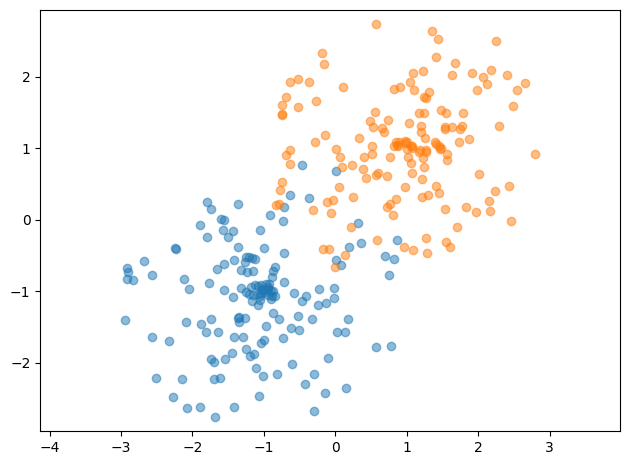

In [18]:
sample1 = uniform_sample_2d((-1, -1), 2, 150, 'A')
sample2 = uniform_sample_2d((1, 1), 2, 150, 'B')

data = [sample1, sample2]

df = pd.DataFrame(columns=['x1', 'x2', 'label'])

for sample in data:
    for feature in sample['features']:
        df.loc[len(df.index)] = [*feature, sample['label']]

for name in df['label'].unique():
    df[f'{name}-label-value'] = df['label'].map(lambda x: 1 if x == name else 0)

for label in df['label'].unique():
    plt.scatter(df[df['label'] == label]['x1'], df[df['label'] == label]['x2'], alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [19]:
test_frac = 0.8

idxs_A = np.random.permutation(np.arange(0, 150))
idxs_B = np.random.permutation(np.arange(150, 300))

test_size_A = int(idxs_A.size*test_frac)
test_size_B = int(idxs_B.size*test_frac)

idx_test_A = idxs_A[0:test_size_A]
idx_test_B = idxs_B[0:test_size_B]

train_size_A = int(idxs_A.size*(1-test_frac))
train_size_B = int(idxs_B.size*(1-test_frac))

idx_train_A = idxs_A[test_size_A:idxs_A.size]
idx_train_B = idxs_B[test_size_B:idxs_B.size]

feature_columns = ['x1', 'x2']
label_columns = ['A-label-value', 'B-label-value']

xTest = np.vstack((
    df.iloc[idx_test_A][feature_columns],
    df.iloc[idx_test_B][feature_columns]
))

yTest = np.vstack((
    df.iloc[idx_test_A][label_columns],
    df.iloc[idx_test_B][label_columns]
))

xTrain = np.vstack((
    df.iloc[idx_train_A][feature_columns],
    df.iloc[idx_train_B][feature_columns]
))

yTrain = np.vstack((
    df.iloc[idx_train_A][label_columns],
    df.iloc[idx_train_B][label_columns]
))

In [20]:
@njit(fastmath=True)
def F(x: np.ndarray) -> np.ndarray:
    # return x
    # return np.maximum(np.zeros(x.shape), x)
    # return np.clip(x,-1, 1)
    return np.tanh(x)


@njit(fastmath=True)
def dF(x: np.ndarray) -> np.ndarray:
    # return np.ones(x.shape)
    # return 1 * (x > 0)
    # return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [21]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, Wh: np.ndarray, Wy: np.ndarray, Bh:np.ndarray, Bx:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dWh = np.zeros(Wh.shape)
    dWy = np.zeros(Wy.shape)
    
    dBh = np.zeros(Bh.shape)
    dBx = np.zeros(Bx.shape)
    db = np.zeros(b.shape)
    
    for i in prange(xBatch.shape[0]):
        Uh = xBatch[i] @ Wh + Bh
        Xh = F(Uh) @ Wh.T + Bx
        y = sigmoid(Xh @ Wy + b)
        
        dWh += np.outer(Xh, (y-yBatch[i]) @ Wy.T @ Wh * dF(Uh))
        dWy += np.outer(Xh, y-yBatch[i])

        dBh += (y-yBatch[i]) @ Wy.T @ Wh * dF(Uh)
        dBx += (y-yBatch[i]) @ Wy.T
        db += y-yBatch[i]
    
    return (dWh, dWy, dBh, dBx, db)


class RBMPerceptron:
    def __init__(self, nH:int, nIn: int, nOut: int) -> None:
        self.nH = nH
        self.nIn = nIn
        self.nOut = nOut
        
        self.Wh: np.ndarray = np.random.uniform(-1, 1, (nIn, nH))
        self.Wy: np.ndarray = np.random.uniform(-1, 1, (nIn, nOut))

        self.Bh: np.ndarray = np.zeros(nH)
        self.Bx: np.ndarray = np.zeros(nIn)
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        Uh = x @ self.Wh + self.Bh
        Yh = F(Uh) @ self.Wh.T + self.Bx
        return softmax(Yh @ self.Wy + self.b)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]

        for k in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)
            
            dWh, dWy, dBh, dBx, db = grads(xTrain[idxs], yTrain[idxs], self.Wh, self.Wy, self.Bh, self.Bx, self.b)
            
            self.Wh -= lr*dWh
            self.Wy -= lr*dWy
            
            self.Bh -= lr*dBh
            self.Bx -= lr*dBx
            self.b -= lr*db
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        yPred = np.array([self.predict(xi) for xi in x])
        h = -1/self.nOut * np.sum(y*np.log(yPred), axis=1)
        return 1/x.shape[0] * np.sum(h)

In [28]:
nH = 2
nIn = 2
nOut = 2

lr = 1e-2
batch_size = 32
max_iter = 500

model = RBMPerceptron(nH, nIn, nOut)

print('untrained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

model.train(xTrain, yTrain, lr, batch_size, max_iter)

print('trained loss: {0:.6f}'.format(model.loss(xTest, yTest)))

yPred = np.array([model.predict(x) for x in xTest])

TP_count = 0
for x, y in zip(xTest, yTest):
    yPred = model.predict(x)
    TP_count += 1 if np.argmax(y) == np.argmax(yPred) else 0

accuracy = TP_count / xTest.shape[0]
print('accuracy: ', accuracy)

untrained loss: 0.364037
trained loss: 0.081273
accuracy:  0.95


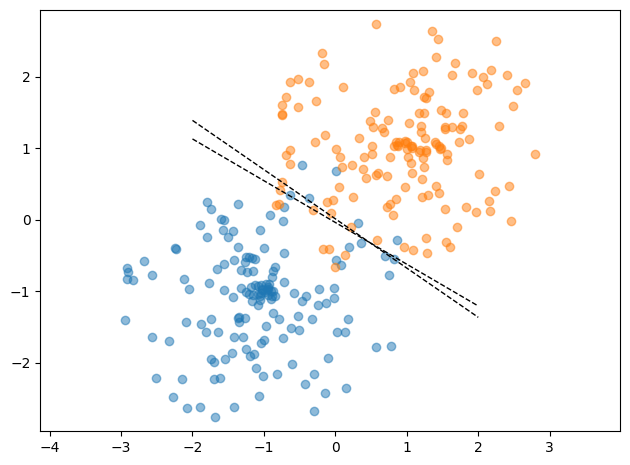

In [29]:
w11, w21, b1 = model.Wy[0][0], model.Wy[1][0], model.b[0]
w12, w22, b2 = model.Wy[0][1], model.Wy[1][1], model.b[1]

x = np.linspace(-2, 2, 100)
y1 = -w11/w21 * x - b1/w21
y2 = -w12/w22 * x - b2/w22

for label in df['label'].unique():
    features = df[df['label'] == label]
    x1, x2 = features['x1'], features['x2']
    plt.scatter(x1, x2, alpha=0.5)

plt.plot(x, y1, c='black', lw=1, ls='--')
plt.plot(x, y2, c='black', lw=1, ls='--')

plt.axis('equal')
plt.tight_layout()
plt.show()